In [1]:
import sys
sys.path.insert(0, '/Users/taku-y/git/github/taku-y/pymc3/')

In [2]:
%pylab inline
import numpy as np
from scipy import stats
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Total sample size is 1000, 10 times larger than the full-batch example (advi.ipynb). 

In [3]:
total_size = 1000
data = np.random.randn(total_size)

To make observed variables be mini-batched, give tensors to their 'observed' arguments. 

In [4]:
import theano.tensor as T

data_t = T.vector()
data_t.tag.test_value=np.zeros(1,)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data_t)
    
minibatch_RVs = [n]
minibatch_tensors = [data_t]

Applied log-transform to sd and added transformed sd_log to model.


Create a generator for mini-batches of size 100. The mini-batches are consumed in the advi function. 

In [5]:
from copy import deepcopy

def create_minibatch(data):
    data_ = deepcopy(data)
    
    while True:
        data_ = np.roll(data_, 100, axis=0)
        yield data_[:100]

minibatches = [create_minibatch(data)]

In [6]:
means, sds, elbos = pm.variational.advi_minibatch(
    model=model, n=40000, minibatch_tensors=minibatch_tensors, 
    minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
    total_size=total_size
)

Iteration 0 [0%]: ELBO = -18199.42
Iteration 4000 [10%]: ELBO = -1589.7
Iteration 8000 [20%]: ELBO = -1659.69
Iteration 12000 [30%]: ELBO = -1506.56
Iteration 16000 [40%]: ELBO = -1523.74
Iteration 20000 [50%]: ELBO = -1515.66
Iteration 24000 [60%]: ELBO = -1517.05
Iteration 28000 [70%]: ELBO = -1516.15
Iteration 32000 [80%]: ELBO = -1521.5
Iteration 36000 [90%]: ELBO = -1525.87
Finished [100%]: ELBO = -1471.46


In [7]:
with pm.Model():
    mu = pm.Normal('mu', mu=0, sd=1, testval=0)
    sd = pm.HalfNormal('sd', sd=1)
    n = pm.Normal('n', mu=mu, sd=sd, observed=data)
    step = pm.NUTS()
    trace = pm.sample(5000, step)

Applied log-transform to sd and added transformed sd_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 1.5 sec

In [8]:
print(trace['mu'].mean())
print(trace['sd_log'].mean())
print(trace['mu'].std())
print(trace['sd_log'].std())

-0.00800816920208
0.00890622414792
0.0323732874514
0.0226791481698


The posterior variance is smaller than the full-batch example because of the total sample size. 

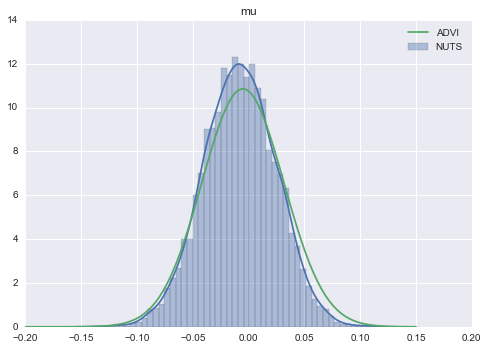

In [9]:
ax = sns.distplot(trace['mu'], label='NUTS')
xlim = ax.get_xlim()
x = np.linspace(xlim[0], xlim[1], 100)
y = stats.norm(means['mu'], sds['mu']).pdf(x)
ax.plot(x, y, label='ADVI')
ax.set_title('mu')
ax.legend(loc=0)

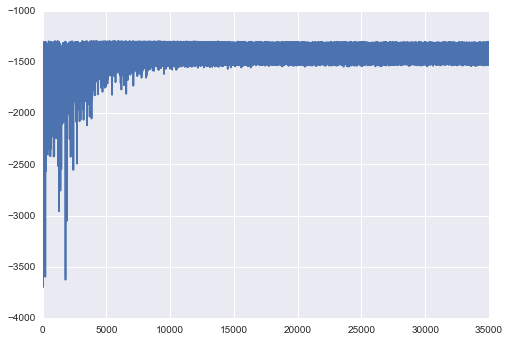

In [10]:
import matplotlib.pyplot as plt
plt.plot(elbos[5000:])